## Imports!

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=7663d1ed58753c6e1aadcd3dcb7f9f213fcc99acc2e9b3435bc790b2da285d73
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
import requests
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, round
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, FloatType
# from pyspark.sql.functions import col, round as spark_round

import pprint
import urllib.request
import zipfile
import os

spark = SparkSession.builder.appName("desafio").getOrCreate()

## Obtenção dos dados de IDH da API

In [3]:
# A priori trabalharemos só com os municípios do estado de São Paulo, (código 35)
ufs=[35]# Deixaremos só São Paulo
ufs

# Criar um df em branco
schema = StructType([
    StructField("localidade", StringType(), True),
    StructField("idh_1991", StringType(), True),
    StructField("idh_2000", StringType(), True),
    StructField("idh_2010", StringType(), True),
])

df_idh = spark.createDataFrame((), schema=schema)
for uf in ufs:
  link = 'https://servicodados.ibge.gov.br/api/v1/pesquisas/indicadores/30255/resultados/'+str(uf)+'xxxx'
  print(link)
  resp = requests.get(link)
  if resp.status_code == 200:
      data = resp.json()
      # pprint.pprint(data)
      for item in data[0]['res']:
          df_idh = df_idh.union(
              spark.createDataFrame([(item['localidade'],item['res']['1991'], item['res']['2000'], item['res']['2010'])],
                                    schema=schema))
  else:
    print('Link não disponível')

conv_a_flot = ["idh_1991", "idh_2000", "idh_2010"]
for coluna in conv_a_flot:
    df_idh = df_idh.withColumn(coluna, col(coluna).cast(FloatType()))

#Criar porcentagem de mudança de IDH de 1991 para 2000
df_idh = df_idh.withColumn('Mudanca_perc_1991_2000', ((col("idh_2000") - col("idh_1991")) / col("idh_1991")) * 100) \
    .withColumn('Mudanca_perc_2000_2010', ((col("idh_2010") - col("idh_2000")) / col("idh_2000")) * 100)

#Criar porcentagem de mudança de IDH de 2000 para 2010
df_idh = df_idh.withColumn('Mudanca_perc_1991_2000', round(col('Mudanca_perc_1991_2000'), 4)) \
    .withColumn('Mudanca_perc_2000_2010', round(col('Mudanca_perc_2000_2010'), 4))


df_idh_pd=df_idh.toPandas()
df_idh_pd.to_excel("df_idh.xlsx")

https://servicodados.ibge.gov.br/api/v1/pesquisas/indicadores/30255/resultados/35xxxx


O Índice de Desenvolvimento Humano (IDH) é calculado considerando 3 fatores principais: Saúde, Educação e Renda.
Na Saúde, considera-se a expectativa de vida da população.
Na Educação, considera-se o índice de alfabetização de adultos e a escolarização da população no geral.
Na Renda considera-se o PIB per capita e a Paridade do Poder de Compra que refletem o padrão de vida da população.
O IDH considera uma ponderação média entre esses 3 fatores, dando como resultado um índice único, categorizado da seguinte forma:

IDH baixo: reúne todos os países que apresentam IDH abaixo de 0,500.
IDH médio: países com IDH entre 0,500 e 0,799.
IDH alto: países com desenvolvimento humano entre 0,800 e 0,899.
IDH muito alto: países cujo índice encontra-se igual ou acima de 0,900."

Observando os resultados, vemos que no geral, todos os municípios tiveram um aumento do IDH, indo em vários casos de baixo pra médio e de médio para alto.

# Obter códigos de 6 dígitos, 7 dígitos e população 2010 dos municípios de São Paulo.

Várias tabelas disponibilizadas pelo IBGE tem códigos identificadores dos municípios usando 6 ou 7 dígitos, precisamos uma tabela para trazer essa informação.

In [4]:
# Criar um df em branco
schema = StructType([
    StructField("IBGE", StringType(), True),
    StructField("IBGE7", StringType(), True),
    StructField("UF", StringType(), True),
    StructField("Município", StringType(), True),
    StructField("pop_2010", FloatType(), True),

])

df_populacao=pd.read_excel('http://blog.mds.gov.br/redesuas/wp-content/uploads/2018/06/Lista-de-Munic%C3%ADpios-com-IBGE-Brasil.xlsx')
# df_populacao

df_populacao=df_populacao[['IBGE', 'IBGE7', 'UF', 'Município','População 2010']]
df_populacao=df_populacao[df_populacao['UF']=='SP']
df_populacao

df_populacao_spark = spark.createDataFrame(df_populacao, schema=schema)

# df_populacao_spark.write.csv('df_populacao.csv', header=True, mode='overwrite')

df_populacao_spark.show()


+------+-------+---+--------------------+--------+
|  IBGE|  IBGE7| UF|           Município|pop_2010|
+------+-------+---+--------------------+--------+
|350010|3500105| SP|          Adamantina| 33797.0|
|350020|3500204| SP|              Adolfo|  3557.0|
|350030|3500303| SP|               Aguaí| 32148.0|
|350040|3500402| SP|      Águas da Prata|  7584.0|
|350050|3500501| SP|    Águas de Lindóia| 17266.0|
|350055|3500550| SP|Águas de Santa Bá...|  5601.0|
|350060|3500600| SP|  Águas de São Pedro|  2707.0|
|350070|3500709| SP|              Agudos| 34524.0|
|350075|3500758| SP|            Alambari|  4884.0|
|350080|3500808| SP|   Alfredo Marcondes|  3891.0|
|350090|3500907| SP|              Altair|  3815.0|
|350100|3501004| SP|         Altinópolis| 15607.0|
|350110|3501103| SP|         Alto Alegre|  4102.0|
|350115|3501152| SP|            Alumínio| 16839.0|
|350120|3501202| SP|    Álvares Florence|  3897.0|
|350130|3501301| SP|     Álvares Machado| 23513.0|
|350140|3501400| SP|  Álvaro de

# Completamos a tabela de população com dados mais atuais obtidos da API.

In [5]:
# Criar um df em branco
schema = StructType([
    StructField("municipio_id", StringType(), True),
    StructField("nome", StringType(), True),
    StructField("pop_2011", StringType(), True),
    StructField("pop_2012", StringType(), True),
    StructField("pop_2013", StringType(), True),
    StructField("pop_2014", StringType(), True),
    StructField("pop_2015", StringType(), True),
    StructField("pop_2016", StringType(), True),
    StructField("pop_2017", StringType(), True),
    StructField("pop_2018", StringType(), True),
    StructField("pop_2019", StringType(), True),
    StructField("pop_2020", StringType(), True),
    StructField("pop_2021", StringType(), True)
])

df_pop = spark.createDataFrame((), schema=schema)
for uf in ufs:
  link='https://servicodados.ibge.gov.br/api/v3/agregados/6579/periodos/2010-2021/variaveis/9324?localidades=N6[N3[35]]'
  print(link)
  resp = requests.get(link)
  if resp.status_code == 200:
      data = resp.json()
      # pprint.pprint(data)
      for item in data[0]['resultados'][0]['series']:
          df_pop = df_pop.union(
              spark.createDataFrame([(item['localidade']['id'], item['localidade']['nome'],  item['serie']['2011'],
                                      item['serie']['2012'],item['serie']['2013'],item['serie']['2014'],item['serie']['2015'],
                                      item['serie']['2016'],item['serie']['2017'],item['serie']['2018'],item['serie']['2019'],
                                      item['serie']['2020'],item['serie']['2021'])],
                                    schema=schema))
  else:
    print('Link não disponível')

conv_a_flot = ["pop_2011", "pop_2012", "pop_2013", "pop_2014", "pop_2015", "pop_2016", "pop_2017", "pop_2018", "pop_2019", "pop_2020", "pop_2021"]
for coluna in conv_a_flot:
    df_pop = df_pop.withColumn(coluna, col(coluna).cast(FloatType()))


df_pop.show()

https://servicodados.ibge.gov.br/api/v3/agregados/6579/periodos/2010-2021/variaveis/9324?localidades=N6[N3[35]]
+------------+--------------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|municipio_id|                nome|pop_2011|pop_2012|pop_2013|pop_2014|pop_2015|pop_2016|pop_2017|pop_2018|pop_2019|pop_2020|pop_2021|
+------------+--------------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|     3500105|     Adamantina - SP| 33821.0| 33843.0| 34953.0| 35001.0| 35048.0| 35094.0| 35139.0| 35023.0| 35068.0| 35111.0| 35153.0|
|     3500204|         Adolfo - SP|  3548.0|  3538.0|  3639.0|  3631.0|  3623.0|  3616.0|  3609.0|  3571.0|  3562.0|  3554.0|  3545.0|
|     3500303|          Aguaí - SP| 32452.0| 32745.0| 34188.0| 34530.0| 34863.0| 35189.0| 35508.0| 35954.0| 36305.0| 36648.0| 36981.0|
|     3500402| Águas da Prata - SP|  7619.0|  7653.0|  7942.0|  7984.0|  8025.

## Juntamos com a primeira tabela de população.

In [6]:
df_populacao_all=df_populacao_spark.join(df_pop,df_populacao_spark.IBGE7==df_pop.municipio_id,how="left")
df_populacao_all.show()

df_populacao_all_pd=df_populacao_all.toPandas()
df_populacao_all_pd.to_excel("df_populacao_all.xlsx")

+------+-------+---+--------------------+--------+------------+--------------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|  IBGE|  IBGE7| UF|           Município|pop_2010|municipio_id|                nome|pop_2011|pop_2012|pop_2013|pop_2014|pop_2015|pop_2016|pop_2017|pop_2018|pop_2019|pop_2020|pop_2021|
+------+-------+---+--------------------+--------+------------+--------------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|350140|3501400| SP|  Álvaro de Carvalho|  4650.0|     3501400|Álvaro de Carvalh...|  4692.0|  4732.0|  4937.0|  4984.0|  5030.0|  5075.0|  5119.0|  5179.0|  5227.0|  5274.0|  5320.0|
|350150|3501509| SP|         Alvinlândia|  3000.0|     3501509|    Alvinlândia - SP|  3013.0|  3025.0|  3137.0|  3153.0|  3168.0|  3182.0|  3196.0|  3206.0|  3222.0|  3237.0|  3251.0|
|350130|3501301| SP|     Álvares Machado| 23513.0|     3501301|Álvares Machado -

No geral, observa-se um aumento da população, porém os dados mostram uma desaceleração do crecimento da população em 2020 que pode ser causado pela pandemía.

# Obter o arquivo do IBGE contendo os códigos dos municípios.

In [7]:
# Baixar arquivo do IBG contendo os códigos dos municípios
link_municipios = 'https://geoftp.ibge.gov.br/organizacao_do_territorio/estrutura_territorial/divisao_territorial/2022/DTB_2022.zip'

arquivo_zip = 'DTB_2022.zip'
urllib.request.urlretrieve(link_municipios, arquivo_zip)

# Extrair arquivos do .zip
with zipfile.ZipFile('/content/DTB_2022.zip', 'r') as zip_ref:
    zip_ref.extractall('')

# Carregar o arquivo excel como um df de pandas
path = '/content/RELATORIO_DTB_BRASIL_MUNICIPIO.xls'
df_pandas = pd.read_excel(path)
# Tirar as primeiras linhas e escolher cabeçalho
df_pandas = df_pandas.iloc[5:].reset_index(drop=True)
df_pandas.columns = df_pandas.iloc[0]
df_pandas = df_pandas.iloc[1:]
df_pandas.columns = df_pandas.columns.str.replace(' ', '_')

# Converter o df de pandas pra spark
df_codmun = spark.createDataFrame(df_pandas)
df_codmun = df_codmun.filter(df_codmun.UF == 35)
df_codmun = df_codmun.select(col('UF'), col('Nome_UF'),col('Microrregião_Geográfica'),col('Nome_Microrregião'),col('Município'),col('Código_Município_Completo'),col('Nome_Município'))
df_codmun.show()


WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
*** No CODEPAGE record, no encoding_override: will use 'iso-8859-1'
+---+---------+-----------------------+--------------------+---------+-------------------------+--------------------+
| UF|  Nome_UF|Microrregião_Geográfica|   Nome_Microrregião|Município|Código_Município_Completo|      Nome_Município|
+---+---------+-----------------------+--------------------+---------+-------------------------+--------------------+
| 35|São Paulo|                    035|          Adamantina|    00105|                  3500105|          Adamantina|
| 35|São Paulo|                    004|São José do Rio P...|    00204|                  3500204|              Adolfo|
| 35|São Paulo|                    029|        Pirassununga|    00303|                  3500303|               Aguaí|
| 35|São Paulo|                    030|São João da Boa V...|    00402|                  3500402|      Águas da Prata|
| 35|São Paulo|                  

## Obter também uma tabela com informação complementar dos distritos e localidades.

In [8]:

link = 'https://servicodados.ibge.gov.br/api/v1/localidades/distritos'
response = requests.get(link)

if response.status_code == 200:
    data = response.json()
    df_distritos = spark.read.json(spark.sparkContext.parallelize([data]))
    # df_distritos.show()
    num_rows = df_distritos.count()
    print("Linhas:", num_rows)
else:
    print("Falha ao trazer os dados:", response.status_code)

df_distritos = df_distritos.withColumn("municipio_id", col("municipio.id")) \
    .withColumn("municipio_nome", col("municipio.nome")) \
    .withColumn("microrregiao_id", col("municipio.microrregiao.id")) \
    .withColumn("microrregiao_nome", col("municipio.microrregiao.nome")) \
    .withColumn("mesorregiao_id", col("municipio.microrregiao.mesorregiao.id")) \
    .withColumn("mesorregiao_nome", col("municipio.microrregiao.mesorregiao.nome")) \
    .withColumn("UF_id", col("municipio.microrregiao.mesorregiao.UF.id")) \
    .withColumn("UF_sigla", col("municipio.microrregiao.mesorregiao.UF.sigla")) \
    .withColumn("UF_nome", col("municipio.microrregiao.mesorregiao.UF.nome")) \
    .withColumn("regiao_id", col("municipio.microrregiao.mesorregiao.UF.regiao.id")) \
    .withColumn("regiao_sigla", col("municipio.microrregiao.mesorregiao.UF.regiao.sigla")) \
    .withColumn("regiao_nome", col("municipio.microrregiao.mesorregiao.UF.regiao.nome"))
df_distritos = df_distritos.drop("municipio")
df_distritos.show()

Linhas: 10670
+---------+--------------------+------------+-------------------+---------------+-------------------+--------------+--------------------+-----+--------+--------------+---------+------------+------------+
|       id|                nome|municipio_id|     municipio_nome|microrregiao_id|  microrregiao_nome|mesorregiao_id|    mesorregiao_nome|UF_id|UF_sigla|       UF_nome|regiao_id|regiao_sigla| regiao_nome|
+---------+--------------------+------------+-------------------+---------------+-------------------+--------------+--------------------+-----+--------+--------------+---------+------------+------------+
|520005005|     Abadia de Goiás|     5200050|    Abadia de Goiás|          52010|            Goiânia|          5203|       Centro Goiano|   52|      GO|         Goiás|        5|          CO|Centro-Oeste|
|310010405| Abadia dos Dourados|     3100104|Abadia dos Dourados|          31019|         Patrocínio|          3105|Triângulo Mineiro...|   31|      MG|  Minas Gerais|   

In [9]:
# df_distritos.show(truncate=False)
df_distritos_filtrado = df_distritos.filter(df_distritos.UF_id == 35)

df_distritos_filtrado_pd=df_distritos_filtrado.toPandas()
df_distritos_filtrado_pd.to_excel("df_distritos_filtrado.xlsx")

# df_codmun_filtrado.show()

# Obter dados do PIB 2021 da API para os municípios de São Paulo

In [10]:
# Criar um df em branco
schema = StructType([
    StructField("municipio_id", StringType(), True),
    StructField("nome", StringType(), True),
    StructField("pib_2010", StringType(), True),
    StructField("pib_2011", StringType(), True),
    StructField("pib_2012", StringType(), True),
    StructField("pib_2013", StringType(), True),
    StructField("pib_2014", StringType(), True),
    StructField("pib_2015", StringType(), True),
    StructField("pib_2016", StringType(), True),
    StructField("pib_2017", StringType(), True),
    StructField("pib_2018", StringType(), True),
    StructField("pib_2019", StringType(), True),
    StructField("pib_2020", StringType(), True),
    StructField("pib_2021", StringType(), True)
])

df_pib = spark.createDataFrame((), schema=schema)
for uf in ufs:
  link = 'https://servicodados.ibge.gov.br/api/v3/agregados/5938/periodos/2010-2021/variaveis/37?localidades=N6[N3[35]]'
  print(link)
  resp = requests.get(link)
  if resp.status_code == 200:
      data = resp.json()
      # pprint.pprint(data)
      for item in data[0]['resultados'][0]['series']:
          df_pib = df_pib.union(
              spark.createDataFrame([(item['localidade']['id'], item['localidade']['nome'], item['serie']['2010'], item['serie']['2011'],
                                      item['serie']['2012'],item['serie']['2013'],item['serie']['2014'],item['serie']['2015'],
                                      item['serie']['2016'],item['serie']['2017'],item['serie']['2018'],item['serie']['2019'],
                                      item['serie']['2020'],item['serie']['2021'])],
                                    schema=schema))
  else:
    print('Link não disponível')

df_pib_pd=df_pib.toPandas()
df_pib_pd.to_excel("df_pib.xlsx")

df_pib.show()

https://servicodados.ibge.gov.br/api/v3/agregados/5938/periodos/2010-2021/variaveis/37?localidades=N6[N3[35]]
+------------+--------------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|municipio_id|                nome|pib_2010|pib_2011|pib_2012|pib_2013|pib_2014|pib_2015|pib_2016|pib_2017|pib_2018|pib_2019|pib_2020|pib_2021|
+------------+--------------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|     3500105|     Adamantina - SP|  639091|  683689|  743684|  815579|  862889| 1059097|  979976| 1040824| 1070910| 1191134| 1243768| 1370866|
|     3500204|         Adolfo - SP|   61059|   68414|   53200|   73529|   76848|   73709|   91756|  100915|   92203|  112493|  136758|  115490|
|     3500303|          Aguaí - SP|  549175|  573702|  568190|  660870|  770055|  670060|  895632|  955578|  972613| 1046725| 1143458| 1314737|
|     3500402| Águas da Pr

Após carregar as tabelas o modelo de dados ficaria:

IDH['localidade']->POPULACAO['IBGE']

POPULACAO['IBGE7']->LOCALIDADE['municipio_id']


LOCALIDADE['municipio_id']->PIB['municipio_id']


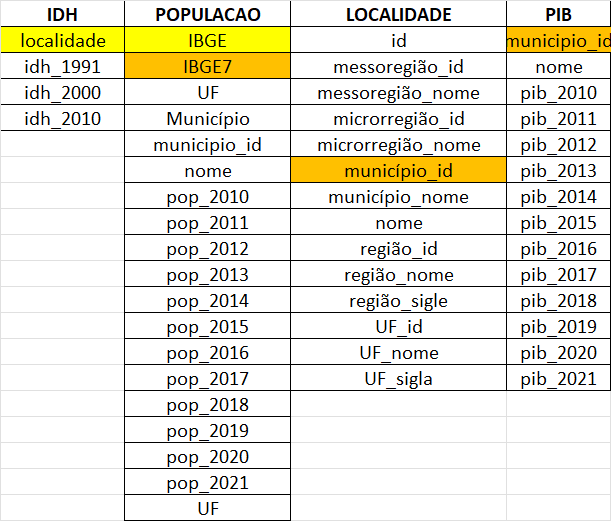










Criaremos um dashboard em Power BI para comprovar o crescimento do PIB , da população e do IDH dos 20 municípios no estado de São Paulo com maior PIB em 2021.